In [44]:
#Lets build the model

import arviz as az
import pymc as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from HelpfulFunctions import clean_and_convert_data
#from HelpfulFunctions import total_point_correction

#Notebook settings
pd.set_option("display.max_columns",None)
sns.set_theme()

In [45]:
# load the data

game_df = clean_and_convert_data('game_season_cleaned.csv')
game_df.sample(5)
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29601 entries, 0 to 29600
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   name                        29601 non-null  string             
 1   position                    29601 non-null  string             
 2   team                        29601 non-null  string             
 3   xP                          29601 non-null  float64            
 4   assists                     29601 non-null  int64              
 5   bonus                       29601 non-null  int64              
 6   bps                         29601 non-null  int64              
 7   clean_sheets                29601 non-null  int64              
 8   creativity                  29601 non-null  float64            
 9   element                     29601 non-null  int64              
 10  expected_assists            29601 non-null  float64       

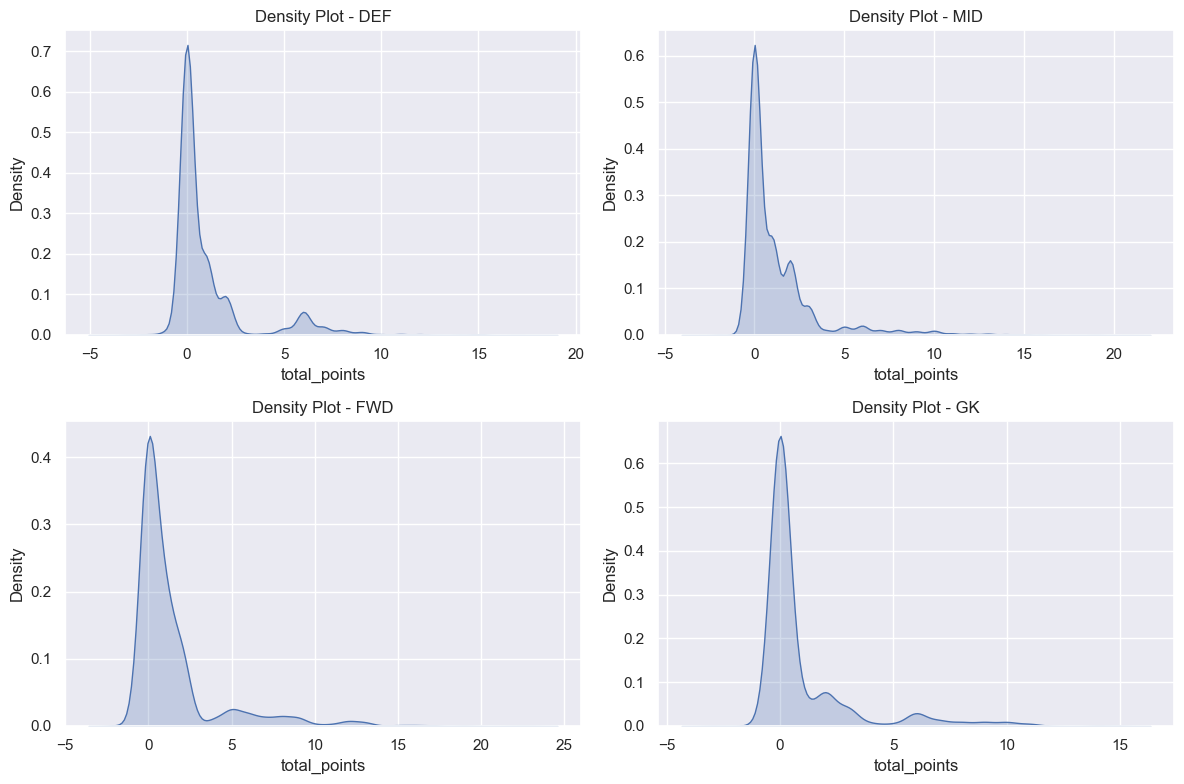

In [46]:
#The concern here is that our target variable has non positive values.
# SInce the aim of the model is to identify high ranking/scoring players, I am not too concerned
# with -ve scores at this point.

# Filter the data for each position
def_data = game_df[game_df['position'] == 'DEF']
mid_data = game_df[game_df['position'] == 'MID']
fwd_data = game_df[game_df['position'] == 'FWD']
gk_data = game_df[game_df['position'] == 'GK']

# Create subplots for each position
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.kdeplot(data=def_data, x='total_points', fill=True)
plt.title('Density Plot - DEF')

plt.subplot(2, 2, 2)
sns.kdeplot(data=mid_data, x='total_points', fill=True)
plt.title('Density Plot - MID')

plt.subplot(2, 2, 3)
sns.kdeplot(data=fwd_data, x='total_points', fill=True)
plt.title('Density Plot - FWD')

plt.subplot(2, 2, 4)
sns.kdeplot(data=gk_data, x='total_points', fill=True)
plt.title('Density Plot - GK')

plt.tight_layout()
plt.show()


In [47]:
# Build a model

modeldata_df = game_df[[
    'GW',
    'position',
    'matchgames',
    'minutes',
    'xP',
    'expected_assists',
    'expected_goal_involvements',
    'expected_goals',
    'expected_goals_conceded',
    'influence',
    'selected',
    'transfers_in',
    'transfers_out',
    'value',
    'previous_points',
    'previous_TotalTeamPoints',
    'total_points'
    
]].dropna()

modeldata_df

,GW,position,matchgames,minutes,xP,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,influence,selected,transfers_in,transfers_out,value,previous_points,previous_TotalTeamPoints,total_points
573,2,MID,2,0,1.0,0.00,0.00,0.0,0.0,0.0,6353,190,826,55,1.0,24.0,0
574,2,MID,2,27,-0.5,0.00,0.00,0.0,0.0,0.0,8333,240,2153,50,1.0,64.0,1
575,2,FWD,2,1,1.0,0.00,0.00,0.0,0.0,0.0,118331,6822,20570,55,1.0,68.0,1
576,2,DEF,2,90,10.0,0.00,0.00,0.0,0.0,20.6,411488,238819,21547,46,15.0,71.0,5
577,2,DEF,2,90,0.0,0.00,0.00,0.0,0.0,14.4,29893,2019,2745,45,1.0,38.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29596,38,MID,38,90,2.0,0.01,0.01,0.0,1.5,0.0,16761,742,642,43,2.0,28.0,2
29597,38,DEF,38,0,0.0,0.00,0.00,0.0,0.0,0.0,58774,24,190,44,0.0,28.0,0
29598,38,DEF,38,0,1.0,0.00,0.00,0.0,0.0,0.0,96712,1522,2668,43,0.0,32.0,0
29599,38,MID,38,0,0.0,0.00,0.00,0.0,0.0,0.0,4511,22,39,45,0.0,33.0,0


In [48]:
# Total points need to be corrected.

def total_point_correction(row):
    '''
    To correct issue with -ve points which is not condusive to my model
    '''
    if row <0:
        result = 0
    else:
        result = row
    return result

#Apply the function


modeldata_df = (modeldata_df
                .assign(
                    total_points_corrected = modeldata_df.total_points.apply(total_point_correction)
                    ))

#Lets check if function works as expected.
modeldata_df.query("total_points < 0")

,GW,position,matchgames,minutes,xP,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,influence,selected,transfers_in,transfers_out,value,previous_points,previous_TotalTeamPoints,total_points,total_points_corrected
585,2,DEF,2,90,-0.5,0.00,0.00,0.00,0.00,21.4,154919,12033,14374,45,1.0,38.0,-1,0
613,2,FWD,2,90,5.5,0.00,0.00,0.00,0.00,5.8,1450647,612051,52742,66,13.0,32.0,-1,0
659,2,DEF,2,90,-2.0,0.00,0.00,0.00,0.00,6.6,4856,87,851,45,0.0,64.0,-1,0
722,2,MID,2,90,1.0,0.00,0.00,0.00,0.00,19.8,567681,43691,43516,50,2.0,20.0,-1,0
760,2,DEF,2,90,0.0,0.00,0.00,0.00,0.00,6.8,368642,27497,40974,50,1.0,17.0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28875,38,FWD,38,79,2.8,0.11,1.29,1.18,2.42,0.0,1439689,56893,13314,66,13.0,35.0,-1,0
28917,38,DEF,38,90,-0.2,0.01,0.01,0.00,2.12,0.0,6101,85,70,44,0.0,27.0,-1,0
29032,38,DEF,21,59,0.4,0.04,0.23,0.19,0.81,0.0,3295,154,115,44,1.0,27.0,-1,0
29237,38,DEF,38,56,2.2,0.18,0.18,0.00,1.54,0.0,43269,15403,513,43,1.0,33.0,-1,0


In [49]:

print(modeldata_df['total_points_corrected'].describe())

count    28779.000000
mean         1.199590
std          2.344041
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         23.000000
Name: total_points_corrected, dtype: float64


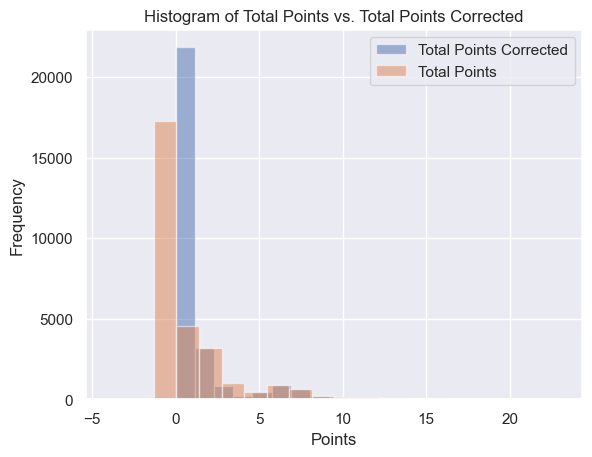

In [50]:




# Create a histogram for 'total_points_corrected'
plt.hist(modeldata_df['total_points_corrected'], bins=20, alpha=0.5, label='Total Points Corrected')

# Create a histogram for 'total_points'
plt.hist(modeldata_df['total_points'], bins=20, alpha=0.5, label='Total Points')

# Add labels and a legend
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.title('Histogram of Total Points vs. Total Points Corrected')
plt.show()


    

/Users/nduqwele/miniconda3/envs/inference/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


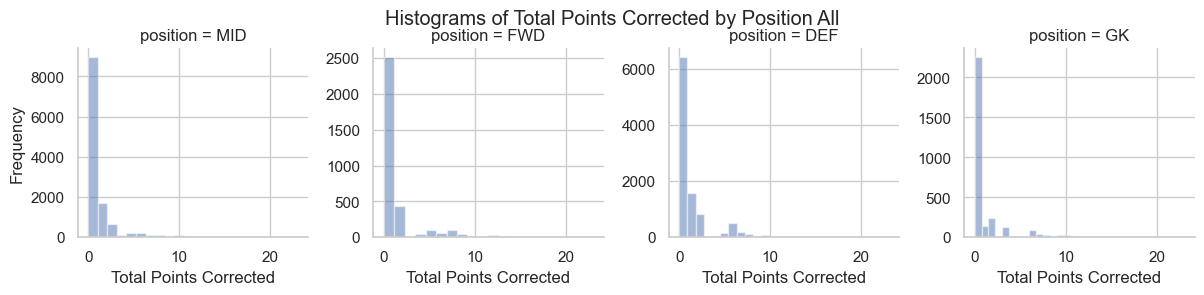

In [51]:
# Set the style of the plots
sns.set(style="whitegrid")

# Create a 4x4 grid of histograms, split by 'position'
g = sns.FacetGrid(modeldata_df, col="position", col_wrap=4, sharey=False)

# Map histograms to 'total_points_corrected' within each grid
g.map(plt.hist, 'total_points_corrected', bins=20, alpha=0.5)

# Set axis labels
g.set_axis_labels("Total Points Corrected", "Frequency")

# Add a title
g.fig.suptitle("Histograms of Total Points Corrected by Position All")

# Adjust spacing between subplots
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()





/Users/nduqwele/miniconda3/envs/inference/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


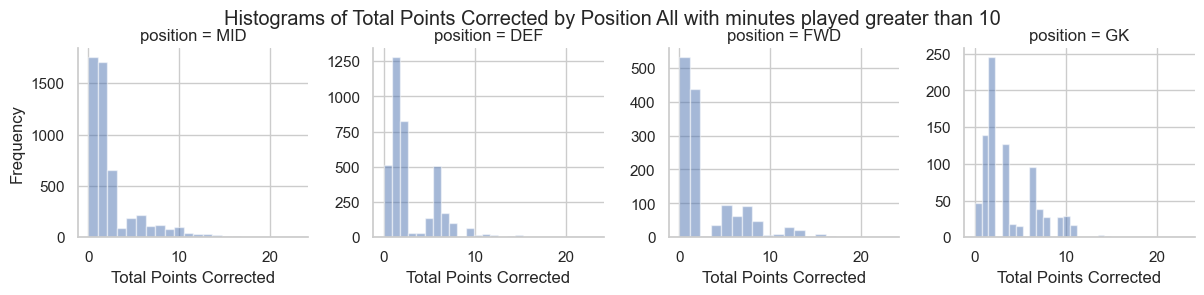

In [52]:
# Set the style of the plots
sns.set(style="whitegrid")


# Create a 4x4 grid of histograms, split by 'position' where minutes played is greater than 10
g = sns.FacetGrid(modeldata_df.query("minutes > 10"), col="position", col_wrap=4, sharey=False)

# Map histograms to 'total_points_corrected' within each grid
g.map(plt.hist, 'total_points_corrected', bins=20, alpha=0.5)

# Set axis labels
g.set_axis_labels("Total Points Corrected", "Frequency")

# Add a title
g.fig.suptitle("Histograms of Total Points Corrected by Position All with minutes played greater than 10")

# Adjust spacing between subplots
plt.subplots_adjust(top=0.85)

# Show the plot
plt.show()


In [53]:
#lets create a indicator function for position field


position_encoded_df =pd.get_dummies(data = modeldata_df,         #input data 
                                    columns=["position"],        # field that we want to create dummy vars
                                    prefix=["ind"],              # prefix for our field name
                                    drop_first=True,             # For Multicollinearity
                                    dtype=int                    # to return 0/1 instead of True/False
                                    )

#we concatonate the fields that we need to the original data set
modeldata_df = pd.concat([modeldata_df, position_encoded_df[['ind_FWD','ind_GK','ind_MID']]], axis=1)
modeldata_df


,GW,position,matchgames,minutes,xP,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,influence,selected,transfers_in,transfers_out,value,previous_points,previous_TotalTeamPoints,total_points,total_points_corrected,ind_FWD,ind_GK,ind_MID
573,2,MID,2,0,1.0,0.00,0.00,0.0,0.0,0.0,6353,190,826,55,1.0,24.0,0,0,0,0,1
574,2,MID,2,27,-0.5,0.00,0.00,0.0,0.0,0.0,8333,240,2153,50,1.0,64.0,1,1,0,0,1
575,2,FWD,2,1,1.0,0.00,0.00,0.0,0.0,0.0,118331,6822,20570,55,1.0,68.0,1,1,1,0,0
576,2,DEF,2,90,10.0,0.00,0.00,0.0,0.0,20.6,411488,238819,21547,46,15.0,71.0,5,5,0,0,0
577,2,DEF,2,90,0.0,0.00,0.00,0.0,0.0,14.4,29893,2019,2745,45,1.0,38.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29596,38,MID,38,90,2.0,0.01,0.01,0.0,1.5,0.0,16761,742,642,43,2.0,28.0,2,2,0,0,1
29597,38,DEF,38,0,0.0,0.00,0.00,0.0,0.0,0.0,58774,24,190,44,0.0,28.0,0,0,0,0,0
29598,38,DEF,38,0,1.0,0.00,0.00,0.0,0.0,0.0,96712,1522,2668,43,0.0,32.0,0,0,0,0,0
29599,38,MID,38,0,0.0,0.00,0.00,0.0,0.0,0.0,4511,22,39,45,0.0,33.0,0,0,0,0,1


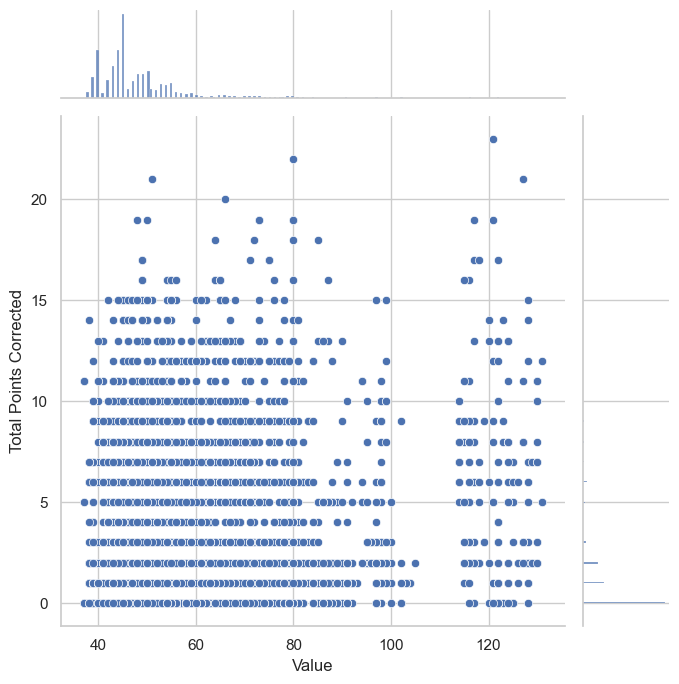

count    28779.000000
mean         1.326099
std          2.304626
min         -3.000000
25%          0.000000
50%          0.200000
75%          2.000000
max         23.600000
Name: xP, dtype: float64


In [54]:
#Scatterplot a simple Poisson Model with simple input 

# Create a jointplot with scatterplot and histograms for the marginals
sns.set(style="whitegrid")
g = sns.jointplot(x='value', y='total_points_corrected', data=modeldata_df, kind="scatter", height=7)

# Set axis labels and a title for the scatterplot
g.set_axis_labels('Value', 'Total Points Corrected')

# Show the plot
plt.show()

print(modeldata_df['xP'].describe())

In [55]:
# Build model with pymc

#lets select players who have some game time
modeldataminutes_df =modeldata_df.query("minutes > 10 and position == 'MID'") 
# lets start with something simple, then we build layers of complexity by trial and error.



with py.Model() as TotalPointsModelSimple:

    # We define our priors
    value = py.Normal("value", mu=49, sigma= 11.423978) # simple describe column variable from the dataframe 
    xP    = py.Normal("xP", mu=1.326, sigma=2.304) # print(modeldata_df['xP'].describe()) to get these values

        # position based 
    ind_FWD	= py.Normal("ind_FWD", mu=0,sigma=1)
    ind_GK	= py.Normal("ind_GK", mu=0,sigma=1)	
    ind_MID	= py.Normal("ind_MID", mu=0,sigma=1)

    #our linear model
    #theta
    theta = (value*modeldataminutes_df['value'].values +
            xP*modeldataminutes_df['xP'].values +
            ind_FWD*modeldataminutes_df['ind_FWD'] +
            ind_GK*modeldataminutes_df['ind_GK'] +
            ind_MID*modeldataminutes_df['ind_MID']
            )
    
    # define our Poisson Likelihood
    y = py.Poisson("y", mu=(theta),observed = (modeldataminutes_df.total_points_corrected.values))




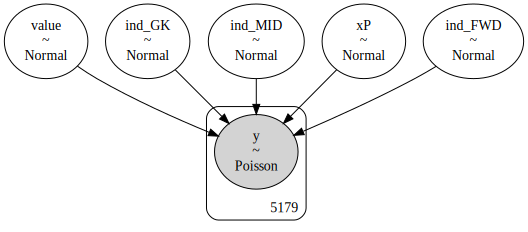

In [56]:
#lets visualize the model
py.model_to_graphviz(TotalPointsModelSimple)


In [57]:
# lets generate a sample

with TotalPointsModelSimple:
    pointsample = py.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value, xP, ind_FWD, ind_GK, ind_MID]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'value'}>],
       [<Axes: title={'center': 'xP'}>, <Axes: title={'center': 'xP'}>],
       [<Axes: title={'center': 'ind_FWD'}>,
        <Axes: title={'center': 'ind_FWD'}>],
       [<Axes: title={'center': 'ind_GK'}>,
        <Axes: title={'center': 'ind_GK'}>],
       [<Axes: title={'center': 'ind_MID'}>,
        <Axes: title={'center': 'ind_MID'}>]], dtype=object)

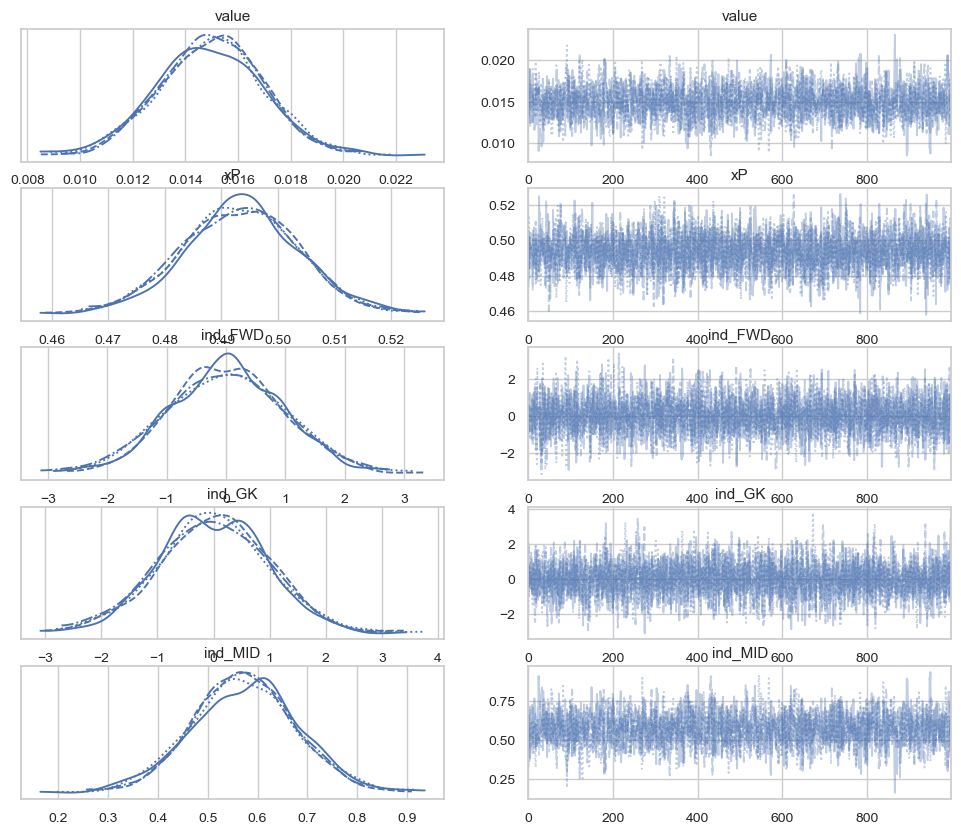

In [58]:
az.plot_trace(pointsample)

### Mental Notes

When the model is restricted to minutes played >10 and positon == MID, we get resonablly stable and quickly convergent model samples. We can add some complexity to the model introducing the indicator Positions and observe if the NUTS sampler converges.